*08/27/24*
Authors: Ismael Mendoza

In [1]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [2]:
import galsim 
import jax_galsim as xgalsim

2024-08-28 06:56:15.768957: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-08-28 06:56:33.504496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tqdm import tqdm

In [5]:
from functools import partial

In [6]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [7]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [8]:
from bpd.chains import inference_loop, inference_loop_multiple_chains

In [9]:
jax.devices()

[CudaDevice(id=0)]

In [10]:
GPU = jax.devices('gpu')[0]

In [11]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Drawing methods

In [12]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [13]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

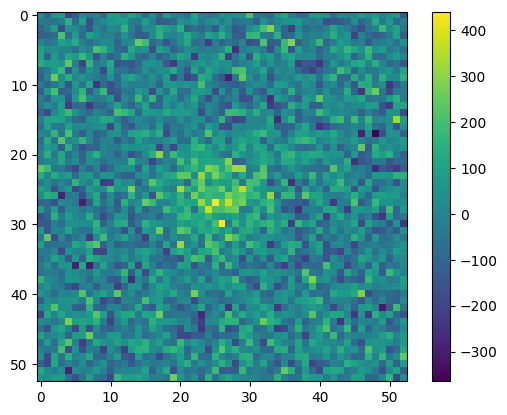

In [14]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [15]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [16]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)
PIXEL_SCALE_GPU = jax.device_put(PIXEL_SCALE, device=GPU)
TEN_GPU = jnp.array(10., device=GPU)
ONE_GPU = jnp.array(1., device=GPU)
PSF_HLR_GPU = jnp.array(PSF_HLR, device=GPU)
SLEN_GPU = jnp.array(SLEN, device=GPU)

def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=TEN_GPU**f, half_light_radius=hlr)
    gal = gal.shift(dx=x*PIXEL_SCALE_GPU, dy=y*PIXEL_SCALE_GPU)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=ONE_GPU, half_light_radius=PSF_HLR_GPU)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN, ## if I change this to SLEN_GPU, get error
                               scale=PIXEL_SCALE_GPU,
                            )
    return image.array

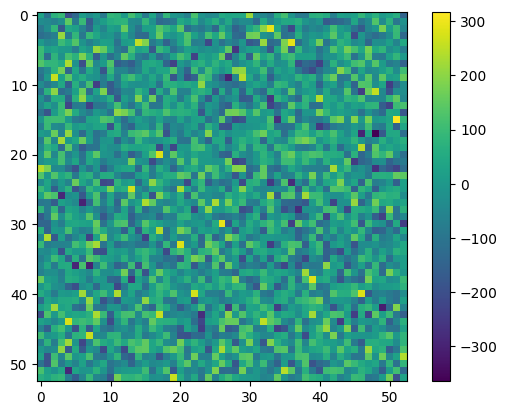

In [17]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

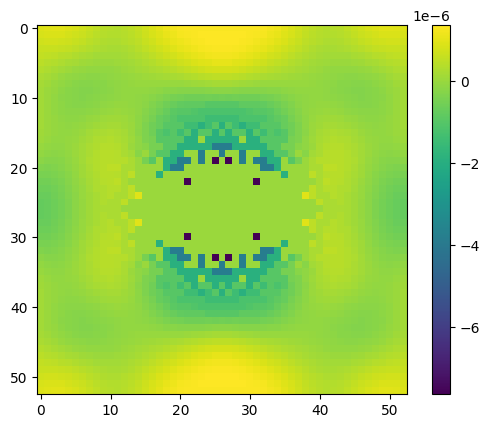

In [18]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [19]:
# gpu
# ERROR internal to jax_galsim! e.g. _hlr_factor inside Gaussian
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
# with jax.transfer_guard('disallow'):
#     draw_gal(**TRUE_PARAMS_GPU)

In [20]:
# timing makes sense
draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU)

%timeit draw_gal_jitted(**TRUE_PARAMS_GPU) # ~ 4x fast
%timeit _draw_gal()

102 μs ± 5.14 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
426 μs ± 16.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [21]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 
          'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': 1,  # sigma (in pixels)
          'y':1 # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [22]:
def _logprob_fn(params, data):    
    #prior
    prior = jnp.array(0., device=GPU) 
    for p in ('f', 'hlr', 'g1', 'g2'): # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)
        
    for p in ('x', 'y'): # normal
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)


# Blackjax NUTS

In [107]:
from bpd.chains import inference_loop, inference_loop_multiple_chains

## Benchmark 1
Metrics as a function of `n_warmup`, same initial position, same data, different random seeds. We also vary 

- `max_num_doublings` 5 vs 10
- Maximum number of chains we can fit in the gpu, timings for each
- Make sure timings are on the compiled jitted functions (warmup and inference_loop)

In [108]:
SEED = 42

In [109]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)


In [110]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)}


In [111]:
init_positions = {**TRUE_PARAMS_GPU}

In [112]:
# what parameter space do we want to explore?
MAX_DOUBLINGS = (5, 10)
N_CHAINS = (1, 5, 10, 25, 50, 100) # probably explodes beyond 1000, starts getting slow ~100
N_WARMUPS = (10, 50, 100, 200, 400, 500, 1000, 2000)

In [113]:
results_dict = {
    'warmup': {
        md:{n_warmups:{} for n_warmups in N_WARMUPS} for md in MAX_DOUBLINGS 
    },
    'inference': {
        md:{n_warmups:{n_chains:{} for n_chains in N_CHAINS} for n_warmups in N_WARMUPS} for md in MAX_DOUBLINGS
    }
}

In [114]:
# warmup function to jit
def call_warmup(rng_key, init_positions, data, n_warmups, max_num_doublings):
    _logdensity = partial(_logprob_fn, data=data)
    warmup = blackjax.window_adaptation(
    blackjax.nuts, _logdensity, progress_bar=False, is_mass_matrix_diagonal=False, 
        max_num_doublings=max_num_doublings, 
        initial_step_size=0.1, 
        target_acceptance_rate=0.90 # sometimes prevents divergences by decrasing final step size, although now priors should be wide enough..
    )
    return warmup.run(rng_key, init_positions, n_warmups) # (init_states, tuned_params), adapt_info

In [117]:
# run a single warmup
print('md, n_warmup')
for md in MAX_DOUBLINGS:
    for n_warmups in N_WARMUPS: # no way to jit over the n_warmup or max_num_doublings
        print(md, n_warmups)
        run_warmup = jjit(partial(call_warmup, n_warmups=n_warmups, max_num_doublings=md))
        
        # compilation time
        t1 = time.time()
        _ = jax.block_until_ready(run_warmup(rng_key, init_positions, data_gpu))
        t2 = time.time()
        results_dict['warmup'][md][n_warmups]['comp_time'] = t2 - t1 
            
            
        # run time
        t1 = time.time()
        (init_states, tuned_params), adapt_info = jax.block_until_ready(run_warmup(rng_key, init_positions, data_gpu))
        t2 = time.time()
        results_dict['warmup'][md][n_warmups]['run_time'] = t2 - t1
        
        # saved parameters to run inference, might also be interesting to track evolution
        results_dict['warmup'][md][n_warmups]['init_states'] = init_states
        results_dict['warmup'][md][n_warmups]['tuned_params'] = tuned_params

print()
print('DONE!')


md, n_warmup
5 10
5 50
5 100
5 200
5 400
5 500
5 1000
5 2000
10 10
10 50
10 100
10 200
10 400
10 500
10 1000
10 2000

DONE!


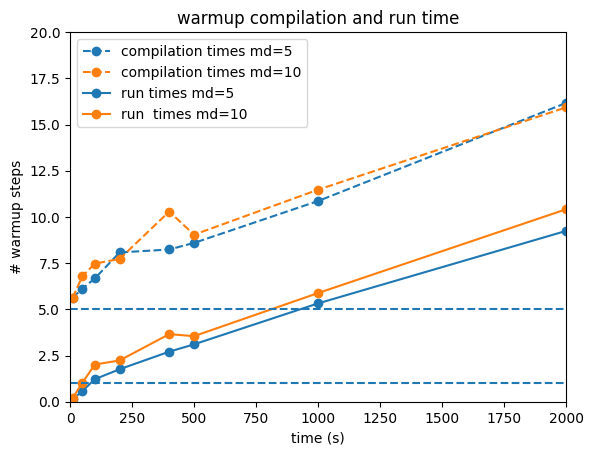

In [118]:
plt.title("warmup compilation and run time")

comp_times1 = [results_dict['warmup'][5][n]['comp_time'] for n in N_WARMUPS]
comp_times2 = [results_dict['warmup'][10][n]['comp_time'] for n in N_WARMUPS]

run_times1 = [results_dict['warmup'][5][n]['run_time'] for n in N_WARMUPS]
run_times2 = [results_dict['warmup'][10][n]['run_time'] for n in N_WARMUPS]


plt.plot(N_WARMUPS, comp_times1, '--o', label='compilation times md=5', color='C0')
plt.plot(N_WARMUPS, comp_times2, '--o', label='compilation times md=10', color='C1')

plt.plot(N_WARMUPS, run_times1, '-o', label='run times md=5', color='C0')
plt.plot(N_WARMUPS, run_times2, '-o', label='run  times md=10', color='C1')

plt.xlabel("time (s)")
plt.ylabel("# warmup steps")

plt.xlim(0, 2000)
plt.ylim(0, 20)
plt.legend()

plt.axhline(1.0, linestyle='--')
plt.axhline(5.0, linestyle='--')

In [119]:
results_dict['warmup'][5][100]['tuned_params'] # example 

{'inverse_mass_matrix': Array([[ 1.25577273e-03, -1.13884581e-03, -2.63128629e-05,
          1.85616268e-03,  2.92933377e-04, -1.24856660e-03],
        [-1.13884581e-03,  7.81109513e-03, -1.70214832e-03,
         -1.88255003e-03,  3.88071257e-03,  6.38630595e-04],
        [-2.63128629e-05, -1.70214832e-03,  8.97191300e-03,
         -1.79363633e-04, -6.46312275e-03, -1.38636225e-03],
        [ 1.85616268e-03, -1.88255003e-03, -1.79363633e-04,
          7.49203937e-03,  1.40432894e-03, -1.15490537e-03],
        [ 2.92933377e-04,  3.88071257e-03, -6.46312275e-03,
          1.40432894e-03,  1.25862739e-01, -5.54959679e-04],
        [-1.24856660e-03,  6.38630595e-04, -1.38636225e-03,
         -1.15490537e-03, -5.54959679e-04,  6.51052724e-02]],      dtype=float64),
 'max_num_doublings': Array(5, dtype=int64, weak_type=True),
 'step_size': Array(0.40256463, dtype=float64, weak_type=True)}

In [120]:
results_dict['warmup'][5][100]['init_states'].position.keys() # ordering of mass matrix

dict_keys(['f', 'g1', 'g2', 'hlr', 'x', 'y'])

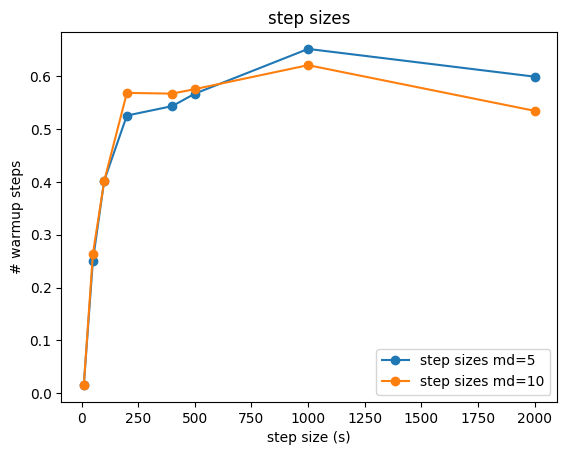

In [121]:
plt.title("step sizes")

step_sizes1 = [results_dict['warmup'][5][n]['tuned_params']['step_size'] for n in N_WARMUPS]
step_sizes2 = [results_dict['warmup'][10][n]['tuned_params']['step_size'] for n in N_WARMUPS]


plt.plot(N_WARMUPS, step_sizes1, '-o', label='step sizes md=5', color='C0')
plt.plot(N_WARMUPS, step_sizes2, '-o', label='step sizes md=10', color='C1')

plt.xlabel("step size (s)")
plt.ylabel("# warmup steps")

plt.legend()



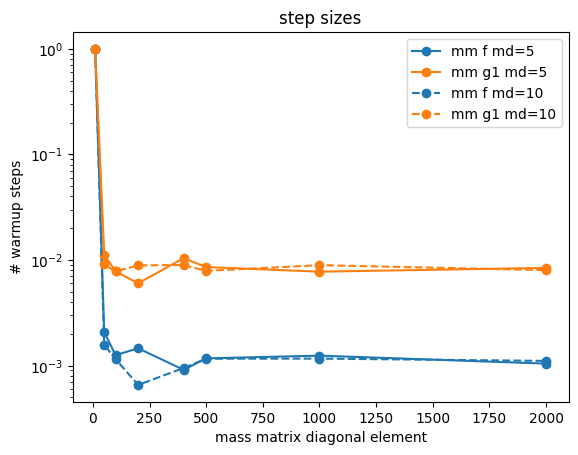

In [122]:
plt.title("step sizes")

mm11 = [results_dict['warmup'][5][n]['tuned_params']['inverse_mass_matrix'][0,0] for n in N_WARMUPS]# f
mm12 = [results_dict['warmup'][5][n]['tuned_params']['inverse_mass_matrix'][1, 1] for n in N_WARMUPS] # g1

mm21 = [results_dict['warmup'][10][n]['tuned_params']['inverse_mass_matrix'][0,0] for n in N_WARMUPS]# f
mm22 = [results_dict['warmup'][10][n]['tuned_params']['inverse_mass_matrix'][1, 1] for n in N_WARMUPS] # g1



plt.plot(N_WARMUPS, mm11, '-o', label='mm f md=5', color='C0')
plt.plot(N_WARMUPS, mm12, '-o', label='mm g1 md=5', color='C1')

plt.plot(N_WARMUPS, mm21, '--o', label='mm f md=10', color='C0')
plt.plot(N_WARMUPS, mm22, '--o', label='mm g1 md=10', color='C1')


plt.xlabel("mass matrix diagonal element")
plt.ylabel("# warmup steps")

plt.legend()

plt.yscale('log')



In [123]:
N_WARMUPS, N_CHAINS, MAX_DOUBLINGS

((10, 50, 100, 200, 400, 500, 1000, 2000), (1, 5, 10, 25, 50, 100), (5, 10))

In [124]:
# vmap only rng_key
def do_inference(rng_key, init_state, data, tuned_params:dict, n_samples:int):
    logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(logdensity, **tuned_params).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=n_samples)
    


In [126]:
# now lets do inference including multilpe chains

# to have a fair comparison (and reduce the total time) we target the same number of samples in all of the configurations
# recall that the interpretation of the warmup is that all chains are ready to sample, no need for "burn-in" samples. 

# run a single warmup
print('md, n_warmup, n_chains')
for md in MAX_DOUBLINGS:
    for n_warmups in N_WARMUPS:
        state = results_dict['warmup'][md][n_warmups]['init_states']
        tuned_params = results_dict['warmup'][md][n_warmups]['tuned_params']
        
        for n_chains in N_CHAINS:
            print(md, n_warmups, n_chains)
            n_samples = 1000 // n_chains # fair timing comparisons, and efficiency
            
            _run_inference = jax.vmap(
                            jax.jit(partial(do_inference, n_samples=n_samples, tuned_params=tuned_params)), 
                            in_axes=(0, None, None)
            )

            keys = random.split(rng_key, n_chains)

            # compilation time
            t1 = time.time()
            _ = jax.block_until_ready(_run_inference(keys, state, data_gpu))
            t2 = time.time()
            results_dict['inference'][md][n_warmups][n_chains]['comp_time'] = t2 - t1 
        
            
            # run time
            t1 = time.time()
            states, info = jax.block_until_ready(_run_inference(keys, state, data_gpu))
            t2 = time.time()
            results_dict['inference'][md][n_warmups][n_chains]['run_time'] = t2 - t1
            
            # save states and info for future reference
            results_dict['inference'][md][n_warmups][n_chains]['states'] = states
            results_dict['inference'][md][n_warmups][n_chains]['info'] = info
            
            
print()
print('DONE!')


md, n_warmup, n_chains
5 10 1
5 10 5
5 10 10
5 10 25
5 10 50
5 10 100
5 50 1
5 50 5
5 50 10
5 50 25
5 50 50
5 50 100
5 100 1
5 100 5
5 100 10
5 100 25
5 100 50
5 100 100
5 200 1
5 200 5
5 200 10
5 200 25
5 200 50
5 200 100
5 400 1
5 400 5
5 400 10
5 400 25
5 400 50
5 400 100
5 500 1
5 500 5
5 500 10
5 500 25
5 500 50
5 500 100
5 1000 1
5 1000 5
5 1000 10
5 1000 25
5 1000 50
5 1000 100
5 2000 1
5 2000 5
5 2000 10
5 2000 25
5 2000 50
5 2000 100
10 10 1
10 10 5
10 10 10
10 10 25
10 10 50
10 10 100
10 50 1
10 50 5
10 50 10
10 50 25
10 50 50
10 50 100
10 100 1
10 100 5
10 100 10
10 100 25
10 100 50
10 100 100
10 200 1
10 200 5
10 200 10
10 200 25
10 200 50
10 200 100
10 400 1
10 400 5
10 400 10
10 400 25
10 400 50
10 400 100
10 500 1
10 500 5
10 500 10
10 500 25
10 500 50
10 500 100
10 1000 1
10 1000 5
10 1000 10
10 1000 25
10 1000 50
10 1000 100
10 2000 1
10 2000 5
10 2000 10
10 2000 25
10 2000 50
10 2000 100

DONE!


In [141]:
results_dict['inference'][5][10][10]['states'].position['f'].shape

(10, 100)

In [142]:
N_WARMUPS

(10, 50, 100, 200, 400, 500, 1000, 2000)

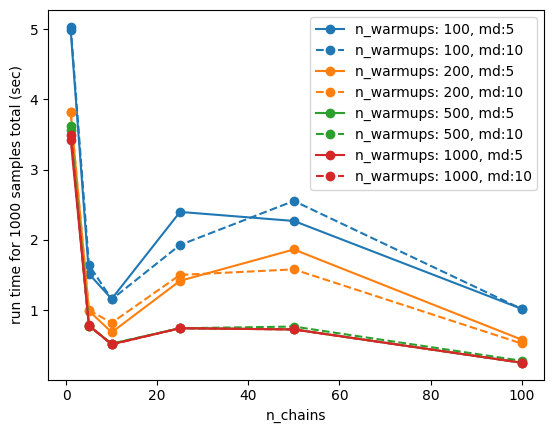

In [143]:
# run_time / compilation time as of n_chains, md (keep in mind same # of samples total)
# for two warmups 

n_warmupss = (100, 200, 500, 1000)
colors = ['C0', 'C1', 'C2', 'C3']


for ii, n_warmups in enumerate(n_warmupss):

    run_times1 = [results_dict['inference'][5][n_warmups][n_chains]['run_time'] for n_chains in N_CHAINS]
    run_times2 = [results_dict['inference'][10][n_warmups][n_chains]['run_time'] for n_chains in N_CHAINS]
    
    plt.plot(N_CHAINS, run_times1, '-o', label=f'n_warmups: {n_warmups}, md:5', color=colors[ii])
    plt.plot(N_CHAINS, run_times2, '--o', label=f'n_warmups: {n_warmups}, md:10', color=colors[ii])
plt.xlabel("n_chains")
plt.ylabel("run time for 1000 samples total (sec)")
plt.legend()

In [144]:
results_dict['inference'][5][100][10]['states'].position['f'].shape # reference

(10, 100)

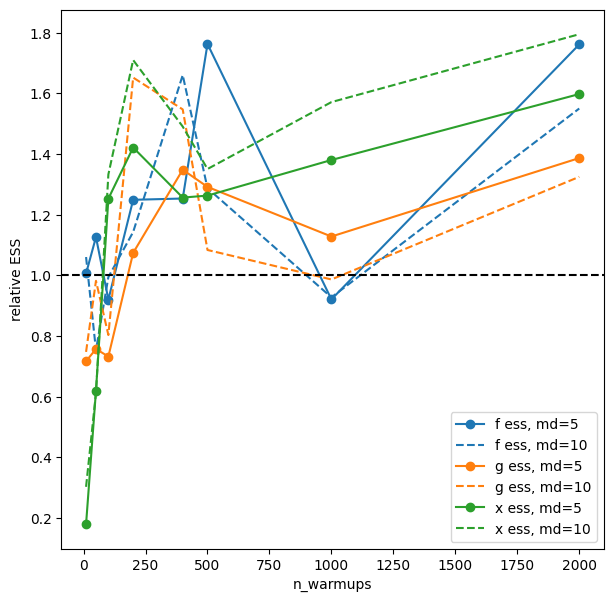

In [145]:
# ESS as a function of n_warmups,md for 5 chains -> 200 samples per chain
plt.figure(figsize=(7,7))

total_n_samples = 1000

ess1 = {p:[] for p in ('f', 'g1', 'g2', 'hlr', 'x', 'y')}
ess2 = {p:[] for p in ('f', 'g1', 'g2', 'hlr', 'x', 'y')}
for n_warmups in N_WARMUPS:
    samples1 = results_dict['inference'][5][n_warmups][5]['states'].position
    samples2 = results_dict['inference'][10][n_warmups][5]['states'].position
    
    
    for p in samples1:
        ess1[p].append(effective_sample_size(samples1[p], chain_axis=0, sample_axis=1)/ total_n_samples)
        ess2[p].append(effective_sample_size(samples2[p], chain_axis=0, sample_axis=1)/total_n_samples)
        
        
plt.plot(N_WARMUPS, ess1['f'], '-o', label='f ess, md=5', color='C0')
plt.plot(N_WARMUPS, ess2['f'], '--', label='f ess, md=10', color='C0')
        
plt.plot(N_WARMUPS, ess1['g1'], '-o', label='g ess, md=5', color='C1')
plt.plot(N_WARMUPS, ess2['g1'], '--', label='g ess, md=10', color='C1')
        
plt.plot(N_WARMUPS, ess1['x'], '-o', label='x ess, md=5', color='C2')
plt.plot(N_WARMUPS, ess2['x'], '--', label='x ess, md=10', color='C2')
    
plt.axhline(1., color='k', linestyle='--')
plt.ylabel("relative ESS")
plt.xlabel("n_warmups")
plt.legend()

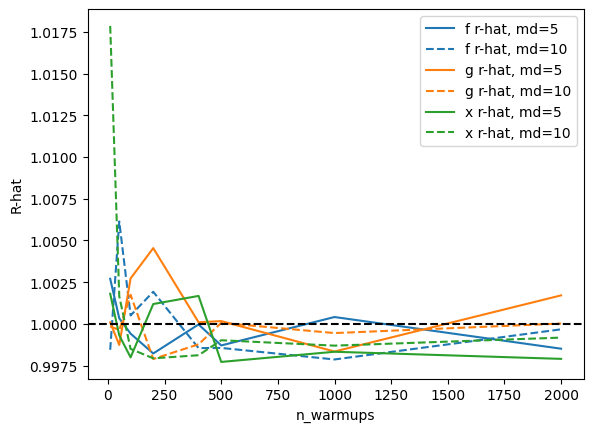

In [146]:
# R-hat as a function of n_warmups,md for 5 chains -> 200 samples per chain
r1 = {p:[] for p in ('f', 'g1', 'g2', 'hlr', 'x', 'y')}
r2 = {p:[] for p in ('f', 'g1', 'g2', 'hlr', 'x', 'y')}
for n_warmups in N_WARMUPS:
    samples1 = results_dict['inference'][5][n_warmups][5]['states'].position
    samples2 = results_dict['inference'][10][n_warmups][5]['states'].position
    
    
    for p in samples1:
        r1[p].append(potential_scale_reduction(samples1[p], chain_axis=0, sample_axis=1))
        r2[p].append(potential_scale_reduction(samples2[p], chain_axis=0, sample_axis=1))
        
        
plt.plot(N_WARMUPS, r1['f'], '-', label='f r-hat, md=5', color='C0')
plt.plot(N_WARMUPS, r2['f'], '--', label='f r-hat, md=10', color='C0')
        
plt.plot(N_WARMUPS, r1['g1'], '-', label='g r-hat, md=5', color='C1')
plt.plot(N_WARMUPS, r2['g1'], '--', label='g r-hat, md=10', color='C1')
        
plt.plot(N_WARMUPS, r1['x'], '-', label='x r-hat, md=5', color='C2')
plt.plot(N_WARMUPS, r2['x'], '--', label='x r-hat, md=10', color='C2')
    
plt.axhline(1.0, color='k', linestyle='--')
plt.ylabel("R-hat")
plt.xlabel("n_warmups")

plt.legend()


In [147]:
# ess / sec as a function of n_chains
# fix n_warmups to 500 per plot above
# fix n_chains = 10 
# perhaps will rerun with more samples so we can do n_chains comparison but it's tricky 

_params = ('f', 'g1', 'g2', 'hlr', 'x', 'y')
_total_n_samples = 1000


samples1 = results_dict['inference'][5][500][5]['states'].position
samples2 = results_dict['inference'][10][500][5]['states'].position

rt1 = results_dict['inference'][5][500][5]['run_time']
rt2 = results_dict['inference'][5][500][5]['run_time']

ess1 = np.mean([effective_sample_size(samples1[p], chain_axis=0, sample_axis=1) for p in _params]) 
ess2 = np.mean([effective_sample_size(samples2[p], chain_axis=0, sample_axis=1) for p in _params])

print('avg ess / sec', ess1 / rt1) 
print('avg ess / sec', ess2 / rt2) 
    



avg ess / sec 1792.4819749141968
avg ess / sec 1636.0281637864086


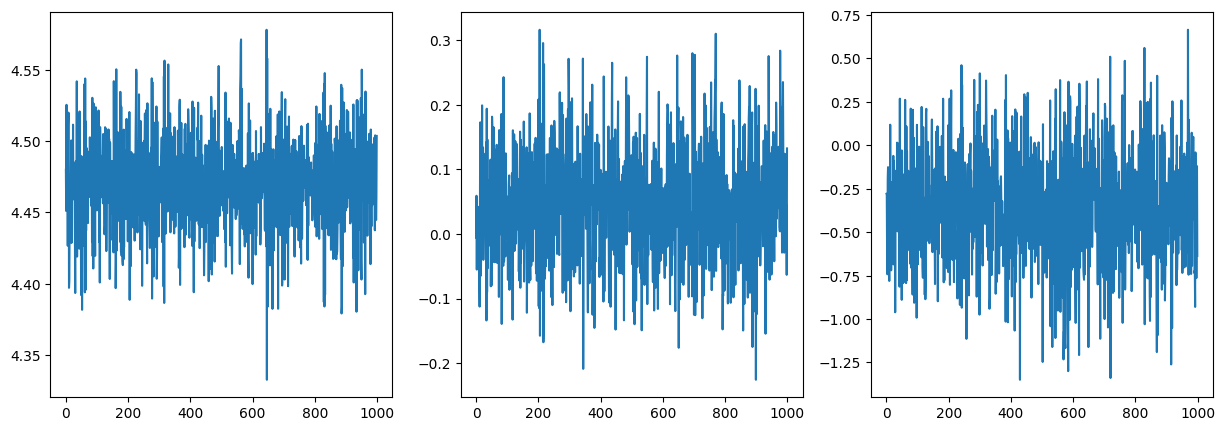

In [148]:
# some example chains f, g1, x
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

samples1 = results_dict['inference'][10][500][1]['states'].position
ax1.plot(samples1['f'][0, :])
ax2.plot(samples1['g1'][0, :])
ax3.plot(samples1['x'][0, :])

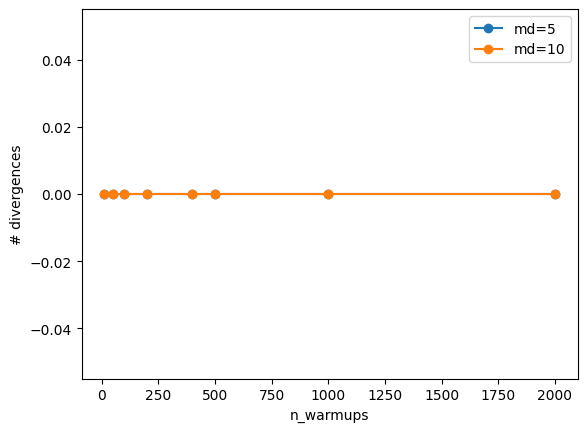

In [149]:
# divergences as function of n_warmups

colors = ['C0', 'C1', 'C2', 'C3']

divs1 = [results_dict['inference'][5][n_warmups][1]['info'].is_divergent.sum() for n_warmups in N_WARMUPS]
divs2 = [results_dict['inference'][10][n_warmups][1]['info'].is_divergent.sum() for n_warmups in N_WARMUPS]

plt.plot(N_WARMUPS, divs1, '-o', label='md=5')
plt.plot(N_WARMUPS, divs2, '-o', label='md=10')

plt.xlabel("n_warmups")
plt.ylabel("# divergences")
plt.legend()

In [ ]:
results_dict1_2 = {
    {
        md:{n_warmups:{n_chains:{} for n_chains in N_CHAINS} for n_warmups in N_WARMUPS} for md in MAX_DOUBLINGS
    }
}

In [ ]:
# for sanity compare with the other way we do multi-chain sampling, should give same timing if I understand vectorization correctly
print('md, n_warmups, n_chains')

# no way to jit over the n_warmup or max_num_doublings
for md in MAX_DOUBLINGS:
    for n_warmups in N_WARMUPS:
        state = results_dict['warmup'][md][n_warmups]['init_states']
        tuned_params = results_dict['warmup'][md][n_warmups]['tuned_params']

        logdensity = partial(_logprob_fn, data=data_gpu)
        kernel = blackjax.nuts(logdensity, **tuned_params).step
        for n_chains in N_CHAINS:
            print(md, n_warmups, n_chains)
            init_states = [state for ii in range(n_chains)] # CHECK
            keys = random.split(rng_key, n_chains)
            _run_inference = jax.jit(partial(inference_loop_multiple_chains, 
                                             n_samples = 1000 // n_chains, # fair runtime comparison
                                             n_chains=n_chains, 
                                             kernel=kernel, 
                                            ))

            # compilation time
            t1 = time.time()
            _ = _run_inference(keys, init_states)
            t2 = time.time()
            results_dict1_2['inference'][md][n_warmups][n_chains]['comp_time'] = t2 - t1 

            # run time
            t1 = time.time()
            states, info = _run_inference(keys, init_states)
            t2 = time.time()
            results_dict1_2['inference'][md][n_warmups][n_chains]['run_time'] = t2 - t1
            
            # save states and info for future reference
            results_dict1_2['inference'][md][n_warmups][n_chains]['states'] = states
            results_dict1_2['inference'][md][n_warmups][n_chains]['info'] = info
            
            
print()
print('DONE!')



In [256]:
results_dict['inference'][n_warmup][md][1]['run_time']

13.291891813278198

## Benchmark 2

We want to repeat the above what each chain will have a different random initial position sampled from the prior.

We again target a single image. 

This time we also vectorize the warmup over each of the chains.

In [91]:
def prior_sample(rng_key, n:int):
    f = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['f'][0], maxval=BOUNDS_GPU['f'][1])
    hlr = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['hlr'][0], maxval=BOUNDS_GPU['hlr'][1])
    g1 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g1'][0], maxval=BOUNDS_GPU['g1'][1])
    g2 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g2'][0], maxval=BOUNDS_GPU['g2'][1])
    x = random.normal(rng_key, (n,)) * BOUNDS_GPU['x'] # mean = 0 
    y = random.normal(rng_key, (n,)) * BOUNDS_GPU['y'] # mean = 0
    
    return {'f': f, 'hlr': hlr, 'g1': g1, 'g2': g2, 'x': x, 'y': y} 

In [95]:
SEED = 42

In [96]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)


In [97]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
prior_key, sample_key, warmup_key = rng_key.split(3)
print(rng_key.devices())

{CudaDevice(id=0)}


In [99]:
# what parameter space do we want to explore?
N_WARMUPS = (10, 50, 100, 200, 500, 1000)
MAX_DOUBLINGS = (5, 10)
N_CHAINS = (1, 5, 10, 25, 50, 100) # probably explodes beyond 1000

In [103]:
results_dict2 = {
        md:{n_warmups:{n_chains:{} for n_chains in N_CHAINS} for n_warmups in N_WARMUPS} for md in MAX_DOUBLINGS
}

In [104]:
all_init_positions = prior_sample(prior_key, max(N_CHAINS)) # subsampel below

In [105]:
# vmap only rng_key
def do_warmup(rng_key, init_position, data, n_warmups:int,  max_num_doublings:int):
    
    _logdensity = partial(_logprob_fn, data=data)
    
    warmup = blackjax.window_adaptation(
    blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False, 
        max_num_doublings=max_num_doublings, 
        initial_step_size=0.1, target_acceptance_rate=0.90
    )    
    return warmup.run(rng_key, init_position, n_warmups) # (init_states, tuned_params), adapt_info

    
def do_inference(rng_key, init_state, data, step_size:float, inverse_mass_matrix, max_num_doublings:int, n_samples:int)
    _logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(_logdensity, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, 
                           max_num_doublings=max_num_doublings).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=n_samples) # state, info
    


In [ ]:
# here we do the warmup independently for every chain regardless of the fact that we target the same data 
# it's an open question whether we can get away with 1 warmup for a given data, but maybe this will help clarify

print('md, n_warmup, n_chains')
for md in MAX_DOUBLINGS:
    for n_warmups in N_WARMUPS:
        for n_chains in N_CHAINS:
            n_samples = 1000 // n_chains
            _run_warmup = jax.vmap(
                            jax.jit(
                                partial(
                                    do_warmup, n_warmups=n_warmups, max_num_doublings=md
                                )
                        ), in_axes=(0, 0, None))
            _run_inference = jax.vmap(
                            jax.jit(
                                partial(
                                    do_inference, n_samples=n_samples, max_num_doublings=md
                                )
                            ), in_axes=(0, 0, None, 0, 0)
            
            # prepare initialization 
            warmup_keys = random.split(warmup_key, n_chains)
            sample_keys = random.split(sample_key, n_chains)
                
            _init_positions = {p:q[:n_chains] for p,q in all_init_positions.items()}
            

            # compilation times
            t1 = time.time()
            (_states, _tuned_params), _ = jax.block_until_ready(_run_warmup(warmup_keys, _init_positions, data=data))
            t2 = time.time()
            results_dict2[md][n_warmups][n_chains]['warmup_comp_time'] = t2 - t1 

            t1 = time.time()
            _ = jax.block_until_readyuntil_ready(_run_inference(keys, _states, data=data, step_size=_tuned_params['step_size'], 
                               inverse_mass_matrix=_tuned_params['inverse_mass_matrix']))
            t2 = time.time()
            results_dict2[md][n_warmups][n_chains]['inference_comp_time'] = t2 - t1 
                
            # run times
            t1 = time.time()
            (states, tuned_params), _ = jax.block_until_ready(_run_warmup(warmup_keys, _init_positions, data=data))
            t2 = time.time()
            results_dict2[md][n_warmups][n_chains]['warmup_run_time'] = t2 - t1 

            t1 = time.time()
            states, infos = jax.block_until_ready(_run_inference(keys, states, data=data, step_size=tuned_params['step_size'], 
                               inverse_mass_matrix=tuned_params['inverse_mass_matrix']))
            t2 = time.time()
            results_dict2[md][n_warmups][n_chains]['inference_run_time'] = t2 - t1 
            
            # save states and info for future reference
            results_dict2[md][n_warmups][n_chains]['states'] = states
            results_dict2[md][n_warmups][n_chains]['info'] = info